<a href="https://colab.research.google.com/github/lokeshpara/Basic-python/blob/master/Copy_of_copy__S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/EVA/S10_Assignment/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/EVA/S10


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import numpy as np
import torchvision.transforms as transforms
import albumentations
from albumentations.pytorch import ToTensor
import random
from GradCAM.gradcam_visualize import GradCAMView
import loader10
import resnet
import train10
import test10
from lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


  pip install torch-lr-finder -v --global-option="amp"


truck truck  deer  deer


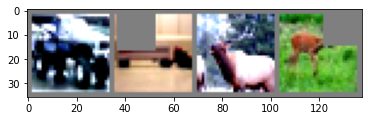

In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(loader10.train_loader_Alb)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


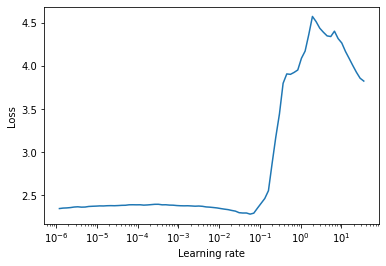

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(loader10.train_loader, end_lr=100, num_iter=100, step_mode="exp")                                
lr_finder.plot() 
#lr_finder.reset()                                                                                                                                              

In [0]:
Best_lr=lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]

In [0]:
lr_finder.reset()

In [0]:
Best_lr

0.05754399373371571

In [0]:
model =  resnet.ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), Best_lr, momentum=0.9, weight_decay=0.0001) 
scheduler = ReduceLROnPlateau(optimizer, patience = 3 , min_lr=1e-4)
loss_func=nn.CrossEntropyLoss()
 
for epoch in range(50):
    print("Epoch:", epoch)
    train10.train(model, device, loader10.train_loader_Albumentation, optimizer, loss_func, epoch)
    # scheduler.step()
    test10.test(model, device, loader10.test_loader,loss_func,last_epoch=True)
    print("lr :" ,)
    scheduler.step(test10.test_losses[-1])

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0


Epoch= 0 Loss=1.9411344528198242 Batch_id=781 Accuracy=37.82: 100%|██████████| 782/782 [01:47<00:00,  7.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 4829/10000 (48.29%)

lr :
Epoch: 1


Epoch= 1 Loss=1.0160883665084839 Batch_id=260 Accuracy=51.83:  33%|███▎      | 260/782 [00:36<01:11,  7.29it/s]

Text(0.5, 1.0, 'Test Accuracy')

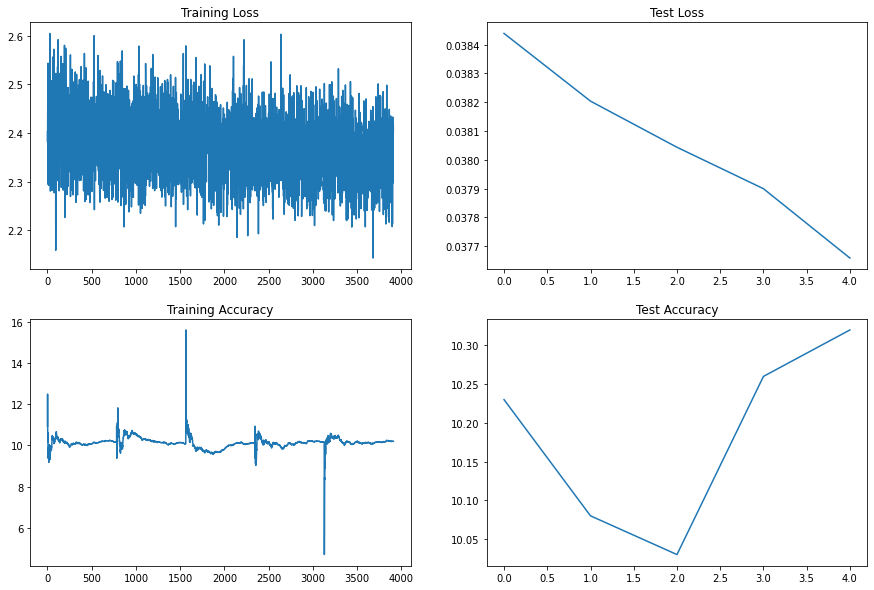

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train10.train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train10.train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test10.test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test10.test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import warnings
warnings.filterwarnings("ignore")
target_layers = ["layer1","layer2","layer3","layer4"]  
grad_cam = GradCAMView(model ,classes,target_layers )  

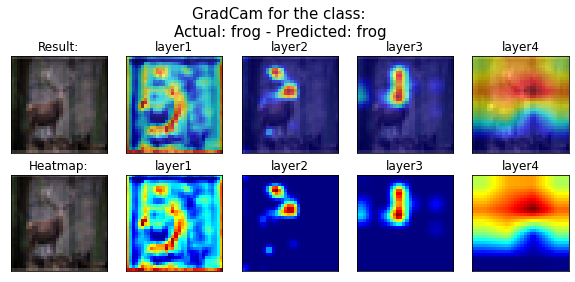

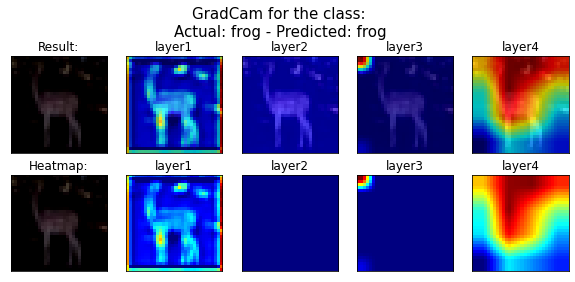

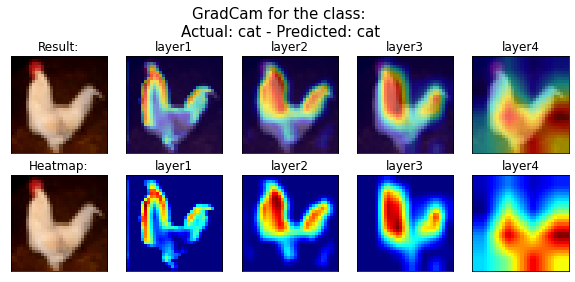

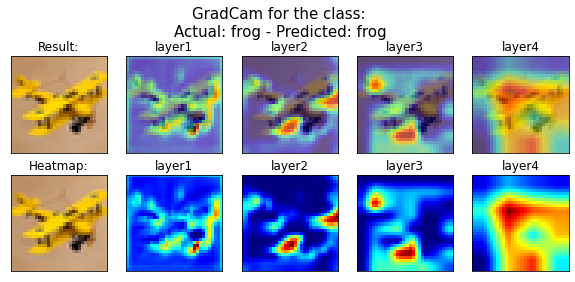

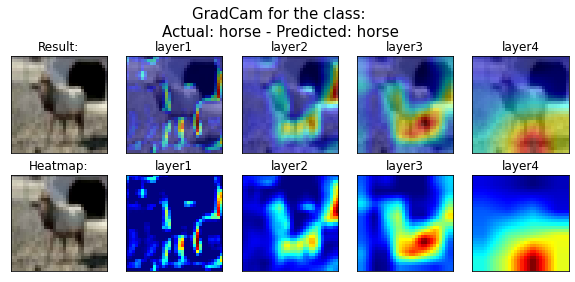

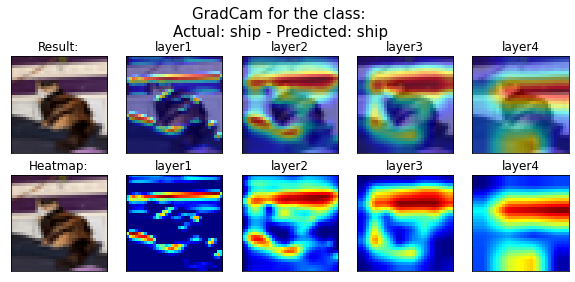

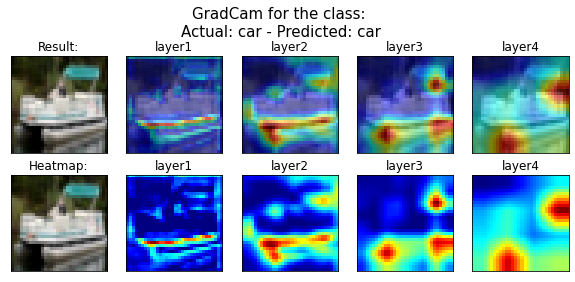

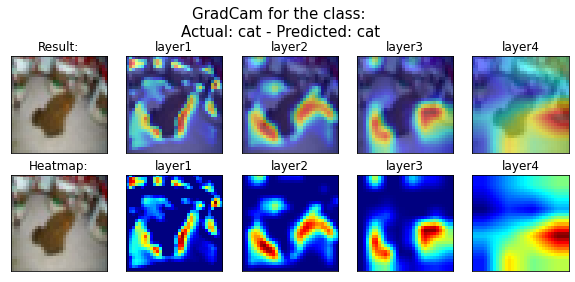

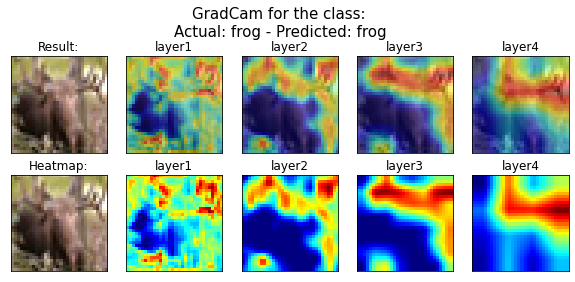

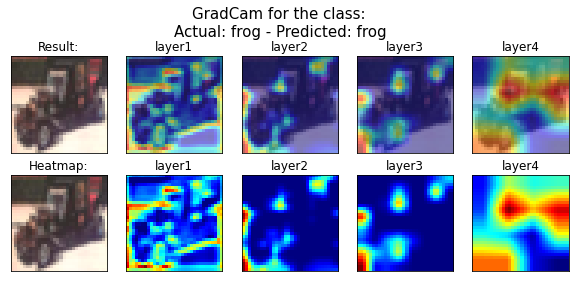

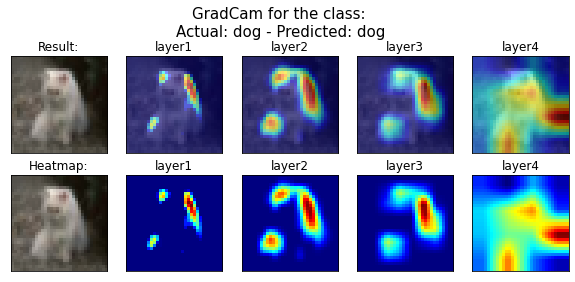

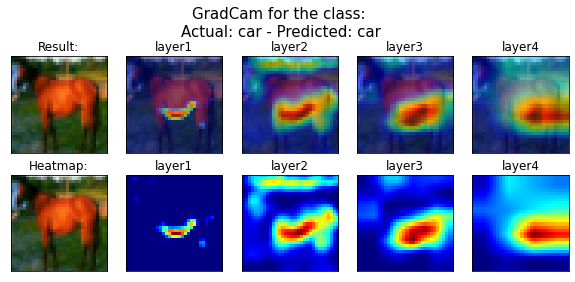

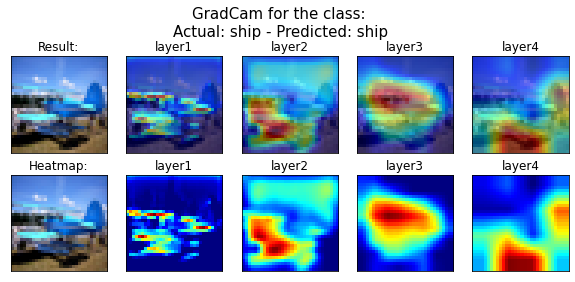

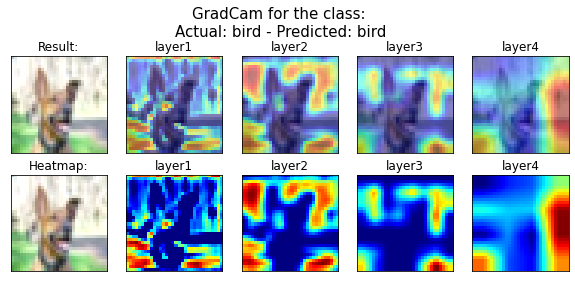

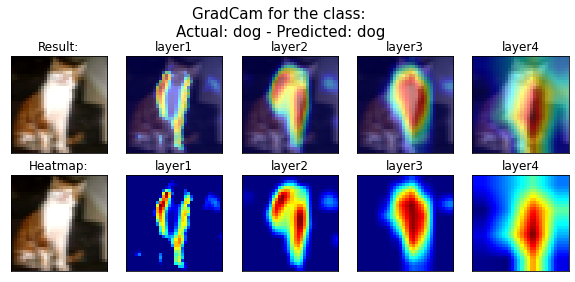

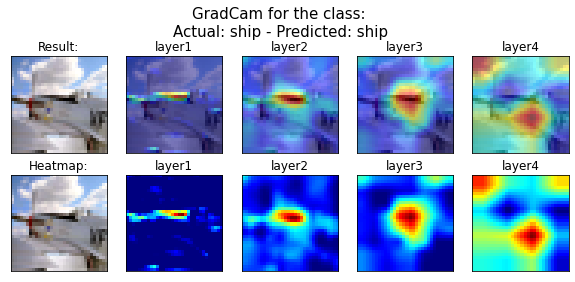

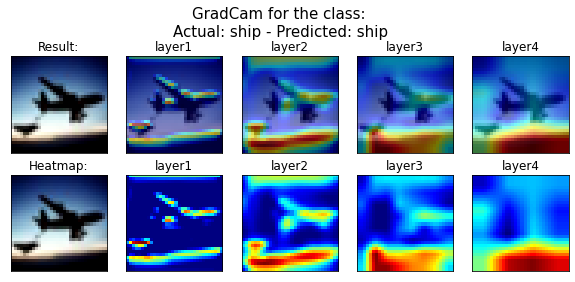

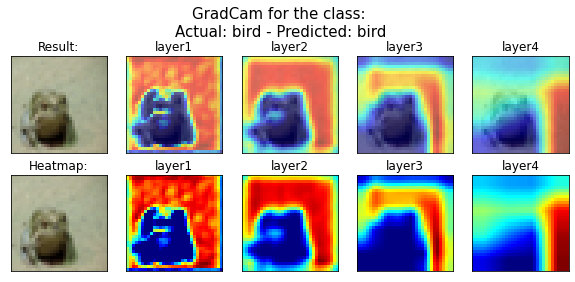

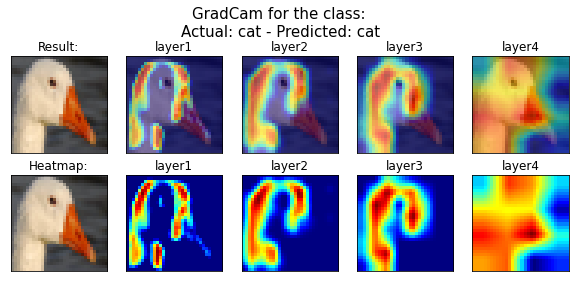

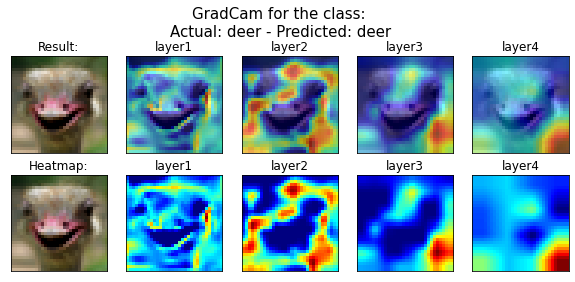

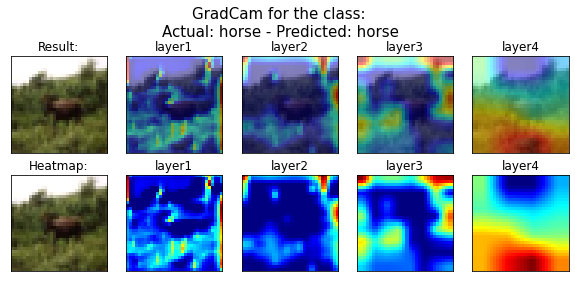

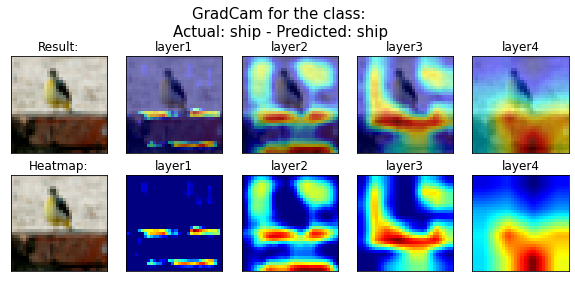

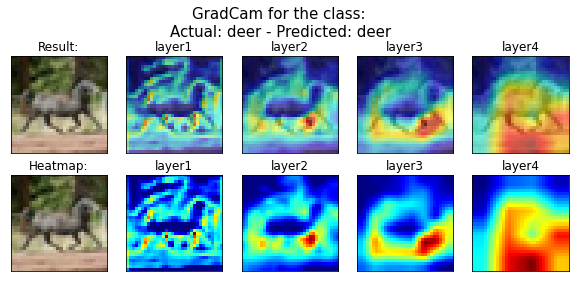

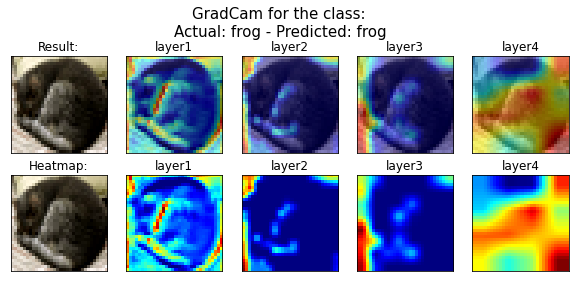

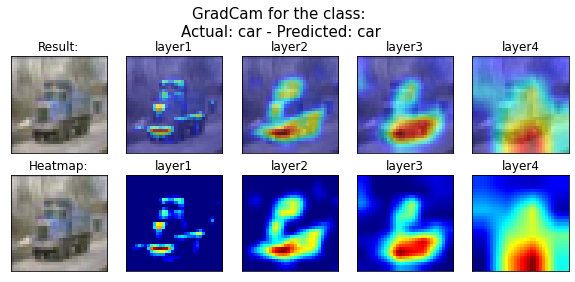

In [0]:
num_img = 25
incorrect_pred_imgs = []
truth_image = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(test10.incorrect_pred[i]["image"]))
  truth_image.append(test10.incorrect_pred[i]["prediction"])
grad_cam(torch.stack(incorrect_pred_imgs), truth_image, target_layers, metric="incorrect",per_image=True)